Demo of current progress with Dataoob

In [1]:
# Imports
import numpy as np
import torch
from matplotlib import pyplot as plt

Global state

In [2]:
from datetime import datetime
device = torch.device("cpu")
random_state = 10
date = datetime.now().strftime("%m-%d_%H:%M")
torch.manual_seed(random_state)

Loading Data

In [3]:
from dataoob.dataloader.loader import DataLoader, mix_labels
from dataoob.evaluator import ExperimentMediator, DataLoaderArgs

dataset_name = "iris"
noise_rate = .1

# Equivalent arguments
loader = (
    DataLoader(dataset_name, False, device, random_state)
    .split_dataset(120, 30)
    .noisify(mix_labels, noise_rate=noise_rate)
)
num_points = len(loader.x_train)
covar_dim = len(loader.x_train[0])
label_dim = loader.y_train.shape[1]

Setting up the models and default arguments

Import models

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from dataoob.model import ClassifierSkLearnWrapper, ClassifierUnweightedSkLearnWrapper
from dataoob.model.logistic_regression import LogisticRegression as LR
from dataoob.model.ann import ANN

In [5]:
models = {
    # Wrappers for sklearn modles, makes the api more cohesive
    'sklogreg': ClassifierSkLearnWrapper(LogisticRegression(), label_dim, device=device),
    'logreg': LR(covar_dim, label_dim).to(device),
    'ann': ANN(covar_dim, label_dim, layers=3, hidden_dim=15).to(device),
    'skknn': ClassifierUnweightedSkLearnWrapper(KNeighborsClassifier(label_dim), label_dim, device=device)
}

Selecting your metrics and model

In [6]:
from dataoob.evaluator import DataEvaluatorArgs
model_name = "ann"
metric_name = "accuracy"
train_kwargs = {"epochs": 30, "batch_size": 20} if model_name in ("ann", "logreg") else {}

de_args = DataEvaluatorArgs(
    pred_model=models[model_name],
    metric_name=metric_name,
    train_kwargs=train_kwargs,
)

Base line model performance

In [7]:
from dataoob.evaluator.api import metrics_dict
model = models[model_name].clone()
x_train, y_train, x_valid, y_valid = loader.datapoints
model.fit(x_train, y_train, **train_kwargs)
metric = metrics_dict[metric_name]

metric(y_valid, model.predict(x_valid))

0.699999988079071

Data Evaluators present

Import data evaluators

In [9]:
from dataoob.dataval.dvrl.dvrl import DVRL
from dataoob.dataval.shap.loo import LeaveOneOut
from dataoob.dataval.oob.oob import DataOob
from dataoob.dataval.knnshap.knnshap import KNNShapley
from dataoob.dataval.shap.datashap import DataShapley
from dataoob.dataval.shap.betashap import BetaShapley
from dataoob.dataval.shap.banzhaf import DataBanzhaf
from dataoob.dataval.dummy import DummyEvaluator
from dataoob.dataval.ame.ame import BaggingEvaluator, AME

In [10]:
dummy_eval = [  # Used for quick testing and run throughs
    DataOob(10, random_state=random_state),
    DVRL(10, rl_epochs=10, random_state=random_state),
    LeaveOneOut(random_state=random_state),
    AME(10, random_state=random_state),
    DataBanzhaf(samples=10, random_state=random_state),
    BetaShapley(100, min_samples=99, model_name="t", random_state=random_state),
    DataShapley(model_name="t", random_state=random_state),
    DataShapley(100, min_samples=99, model_name="r", random_state=random_state),
]

data_evaluators = [  # actual run through of experiments, will take long time 
    DataOob(random_state=random_state),
    DVRL(rl_epochs=4000, random_state=random_state),
    LeaveOneOut(random_state=random_state),
    AME(random_state=random_state),
    DataBanzhaf(15000, random_state=random_state),
    BetaShapley(gr_threshold=1.005, min_samples=500, model_name="t", random_state=random_state),
    DataShapley(gr_threshold=1.005, min_samples=500, model_name="t", random_state=random_state),
]

Setting up the Evaluator Mediator

In [11]:
exper_med = ExperimentMediator(loader, data_evaluators, de_args.pred_model, de_args.train_kwargs, de_args.metric_name)
# evalpipe = ExperimentMediator(
#     loader, dummy_eval, pred_model=models[model_name], train_kwargs=train_kwargs
# )

100%|██████████| 15000/15000 [17:43<00:00, 14.10it/s]

Start: marginal contribution computation



100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


gr_stat=100


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


gr_stat=100


100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


gr_stat=100


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


gr_stat=100


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


gr_stat=1.0175839009445526


100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


gr_stat=1.0129693403288844


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


gr_stat=1.0116524904488642


100%|██████████| 100/100 [01:20<00:00,  1.23it/s]


gr_stat=1.0072934318582676


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


gr_stat=1.0108045348927253


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


gr_stat=1.007128856715485


100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


gr_stat=1.0078434113326884


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


gr_stat=1.0115981768843278


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


gr_stat=1.0062404846827806


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


gr_stat=1.0053254503433318


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


gr_stat=1.0068077479748514


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]

gr_stat=1.0049886126637078
Done: marginal contribution computation


Plotting and getting results

In [12]:
# Imports
from dataoob.evaluator.exper_methods import (
    discover_corrupted_sample, noisy_detection, remove_high_low, point_addition
)
import os
output_dir = f"tmp/{dataset_name}{noise_rate=}/{date}/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

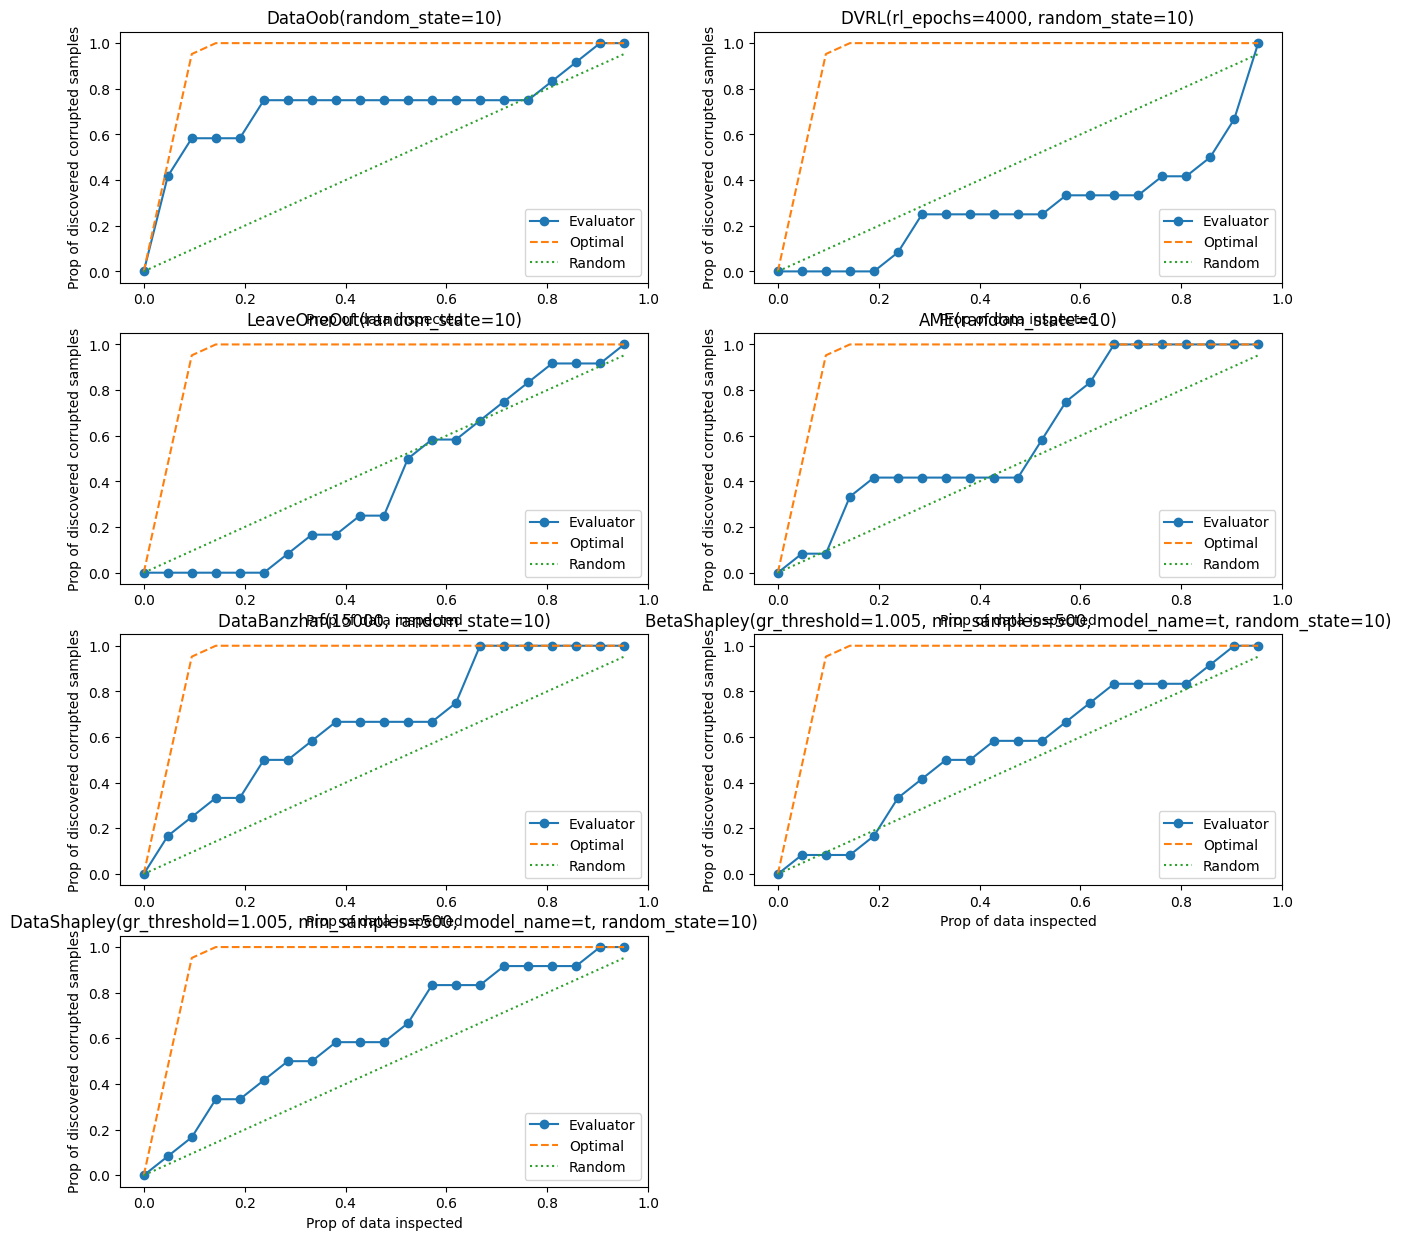

In [22]:
fig = plt.figure(figsize=(15, 15))
df_resp = exper_med.plot(discover_corrupted_sample, fig, col=2)
df_resp[0].to_csv(f"{output_dir}/discover_corrupted_sample.csv")

In [23]:
df_resp = exper_med.evaluate(noisy_detection)
df_resp.to_csv(f"{output_dir}/noisy_detection.csv")
df_resp

0
recall    DataOob(random_state=10)                            0.583333
          DVRL(rl_epochs=4000, random_state=10)               0.000000
          LeaveOneOut(random_state=10)                        0.000000
          AME(random_state=10)                                0.083333
          DataBanzhaf(15000, random_state=10)                 0.250000
          BetaShapley(gr_threshold=1.005, min_samples=500...  0.083333
          DataShapley(gr_threshold=1.005, min_samples=500...  0.166667
kmeans_f1 DataOob(random_state=10)                            0.773481
          DVRL(rl_epochs=4000, random_state=10)               0.093023
          LeaveOneOut(random_state=10)                        0.000000
          AME(random_state=10)                                0.400000
          DataBanzhaf(15000, random_state=10)                 0.496552
          BetaShapley(gr_threshold=1.005, min_samples=500...  0.000000
          DataShapley(gr_threshold=1.005, min_samples=500...  0.186047

<Figure size 1500x1500 with 0 Axes>

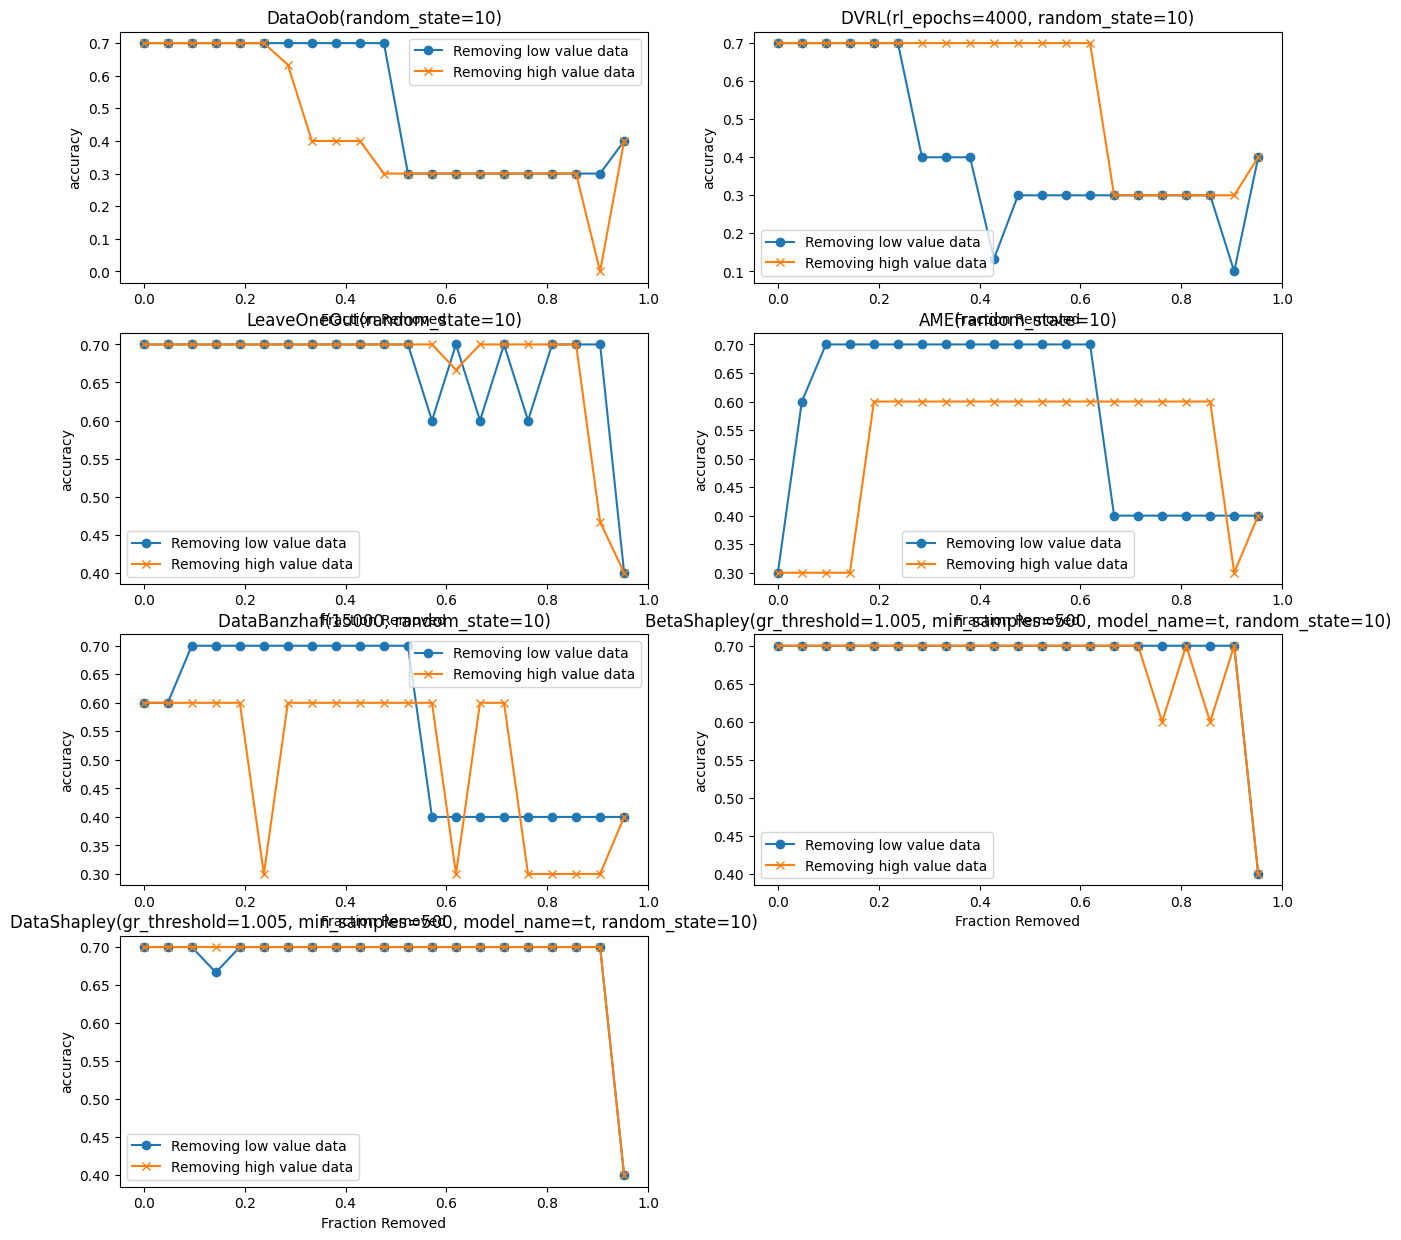

In [24]:
fig = plt.figure(figsize=(15, 15))
df_resp, fig = exper_med.plot(remove_high_low, include_train=True, col=2)
df_resp.to_csv(f"{output_dir}/remove_high_low.csv")

<Figure size 1500x1500 with 0 Axes>

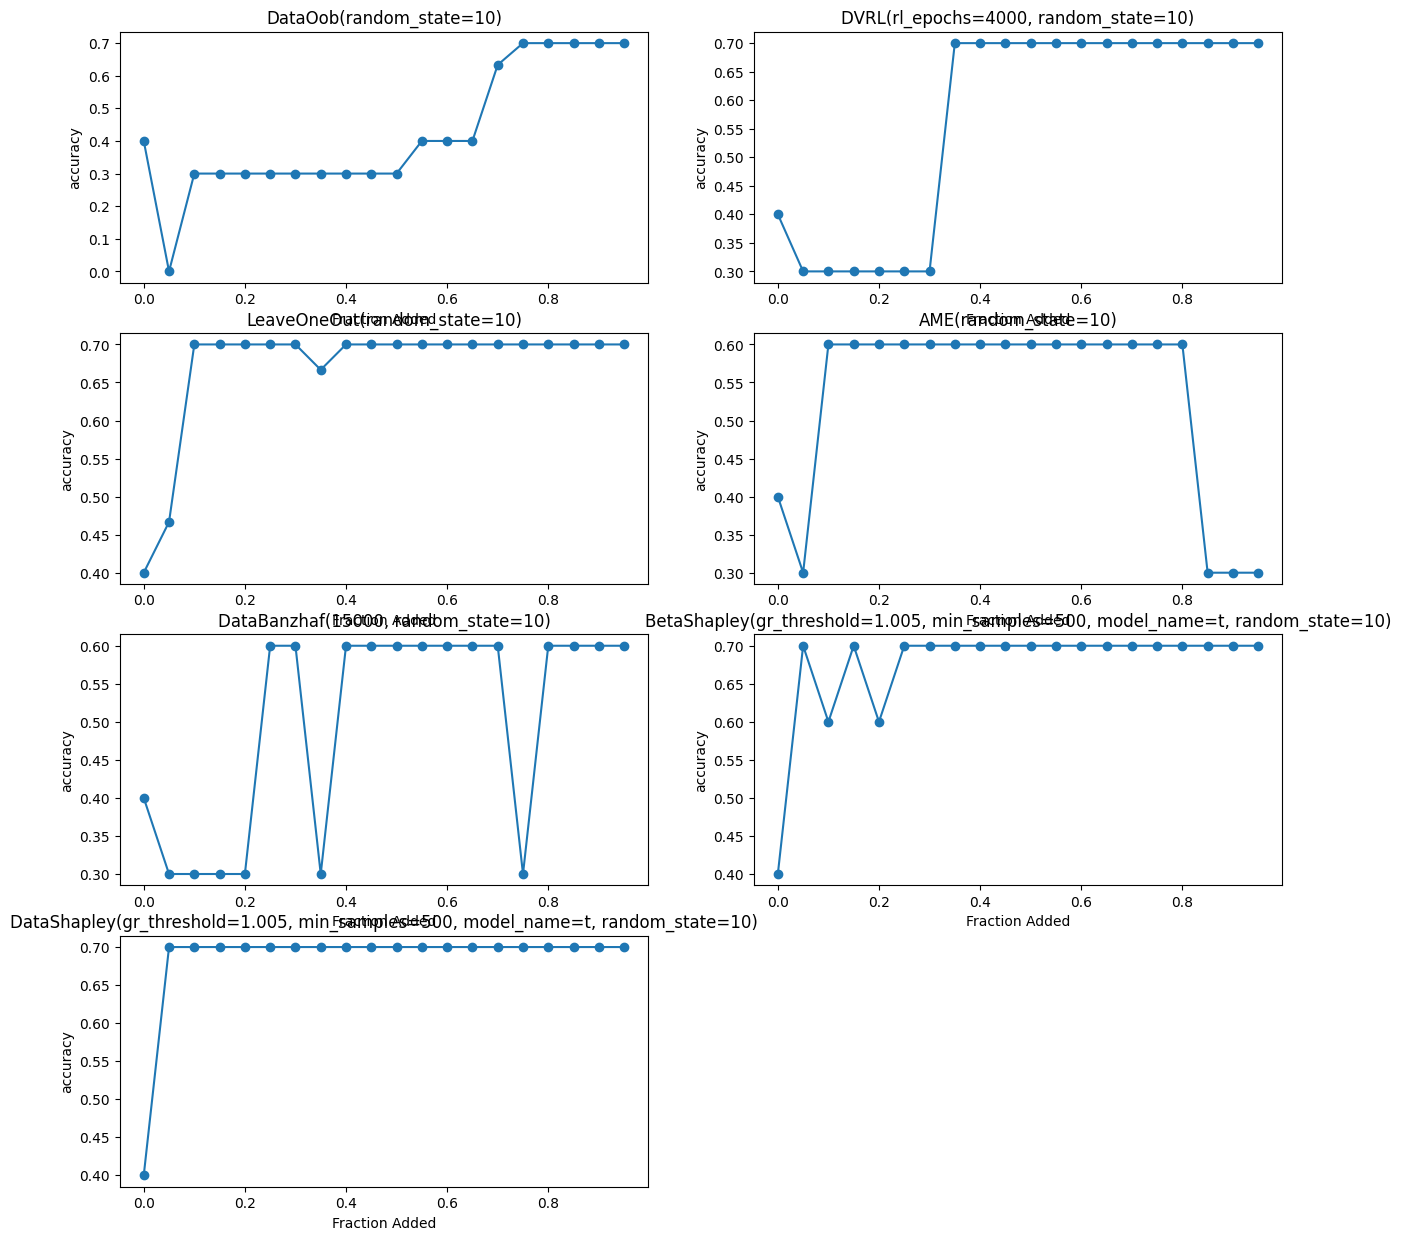

In [25]:
fig = plt.figure(figsize=(15, 15))
df_resp, fig = exper_med.plot(point_addition, include_train=True, col=2, order="ascending")
df_resp.to_csv(f"{output_dir}/descending_add.csv")

<Figure size 1500x1500 with 0 Axes>

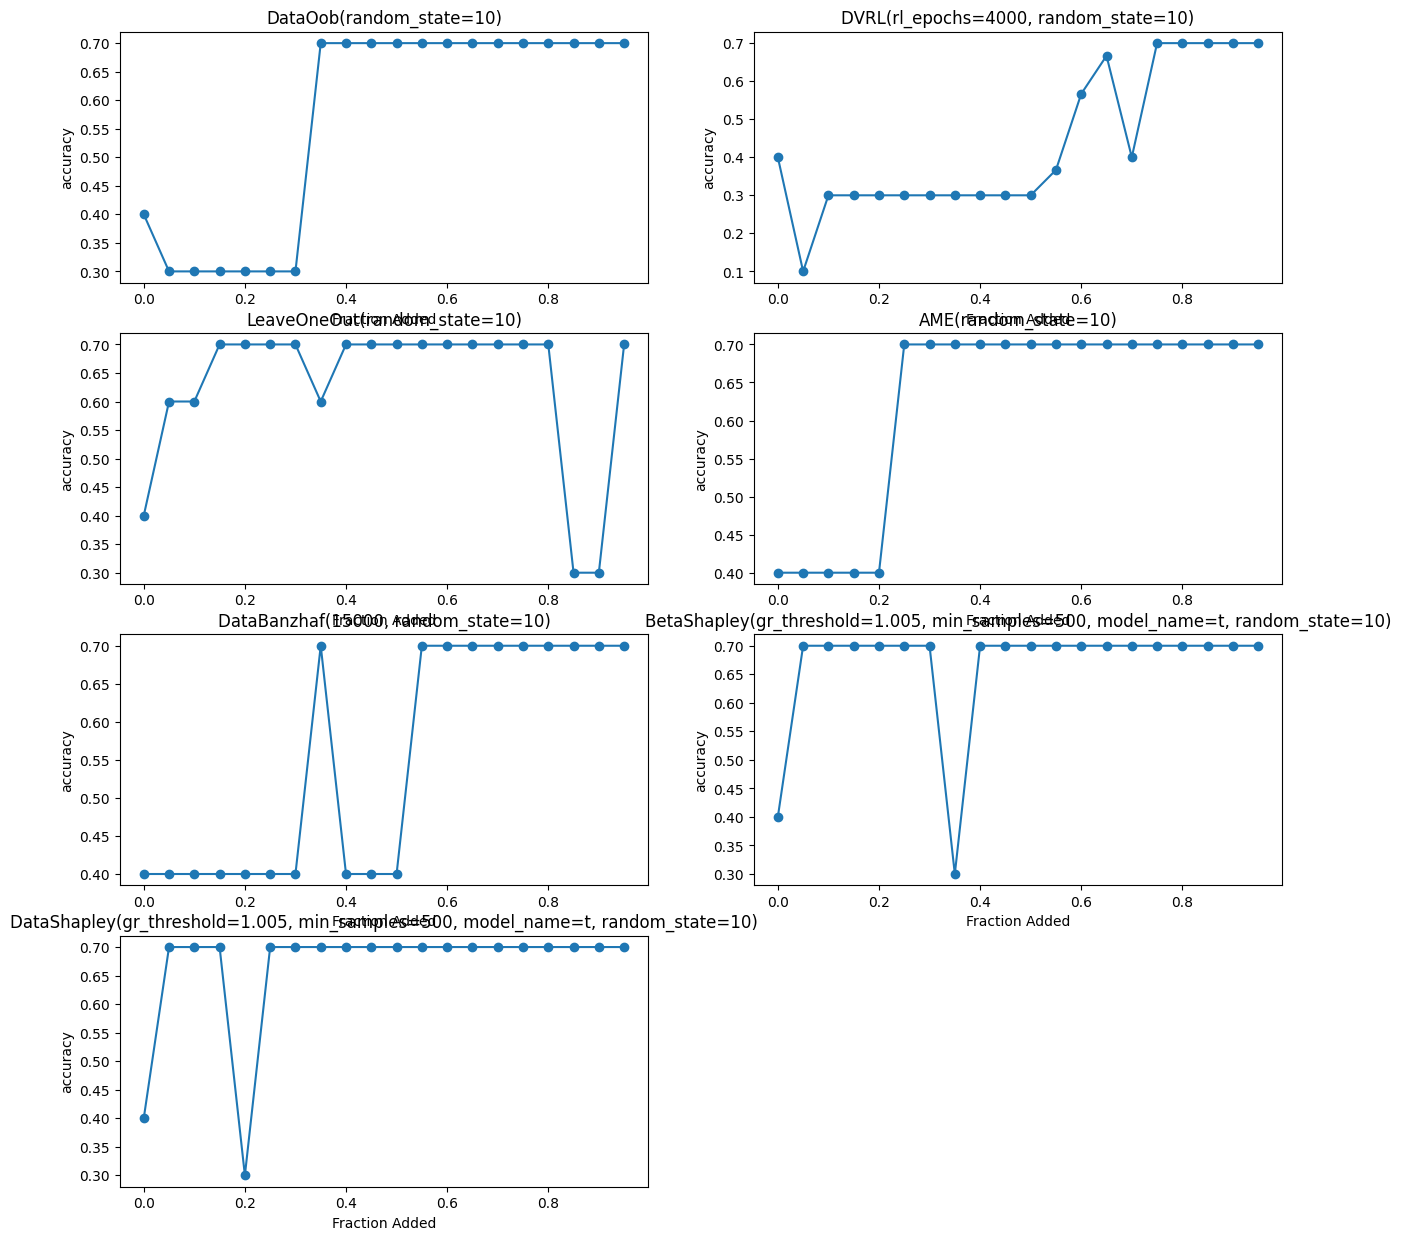

In [17]:
fig = plt.figure(figsize=(15, 15))
df_resp, fig = exper_med.plot(point_addition, include_train=True, col=2, percentile=.01, order="descending")
df_resp.to_csv(f"{output_dir}/ascending_add.csv")

In [26]:
import pandas as pd
def read_saved_csv(file_path: str):
    return pd.read_csv(file_path, index_col=[0, 1])
read_saved_csv(f"{output_dir}/discover_corrupted_sample.csv")

0  \
corrupt_found DataOob(random_state=10)                            0.0   
              DVRL(rl_epochs=4000, random_state=10)               0.0   
              LeaveOneOut(random_state=10)                        0.0   
              AME(random_state=10)                                0.0   
              DataBanzhaf(15000, random_state=10)                 0.0   
              BetaShapley(gr_threshold=1.005, min_samples=500...  0.0   
              DataShapley(gr_threshold=1.005, min_samples=500...  0.0   
axis          DataOob(random_state=10)                            0.0   
              DVRL(rl_epochs=4000, random_state=10)               0.0   
              LeaveOneOut(random_state=10)                        0.0   
              AME(random_state=10)                                0.0   
              DataBanzhaf(15000, random_state=10)                 0.0   
              BetaShapley(gr_threshold=1.005, min_samples=500...  0.0   
              DataShapley(gr_threshold=1.005, min_samples=500...  0.0   
optimal       DataOob(random_state=10)                            0.0   
              DVRL(rl_epochs=4000, random_state=10)               0.0   
              LeaveOneOut(random_state=10)                        0.0   
              AME(random_state=10)                                0.0   
              DataBanzhaf(15000, random_state=10)                 0.0   
              BetaShapley(gr_threshold=1.005, min_samples=500...  0.0   
              DataShapley(gr_threshold=1.005, min_samples=500...  0.0   
random        DataOob(random_state=10)                            0.0   
              DVRL(rl_epochs=4000, random_state=10)               0.0   
              LeaveOneOut(random_state=10)                        0.0   
              AME(random_state=10)                                0.0   
              DataBanzhaf(15000, random_state=10)                 0.0   
              BetaShapley(gr_threshold=1.005, min_samples=500...  0.0   
              DataShapley(gr_threshold=1.005, min_samples=500...  0.0   

                                                                         1  \
corrupt_found DataOob(random_state=10)                            0.416667   
              DVRL(rl_epochs=4000, random_state=10)               0.000000   
              LeaveOneOut(random_state=10)                        0.000000   
              AME(random_state=10)                                0.083333   
              DataBanzhaf(15000, random_state=10)                 0.166667   
              BetaShapley(gr_threshold=1.005, min_samples=500...  0.083333   
              DataShapley(gr_threshold=1.005, min_samples=500...  0.083333   
axis          DataOob(random_state=10)                            0.047619   
              DVRL(rl_epochs=4000, random_state=10)               0.047619   
              LeaveOneOut(random_state=10)                        0.047619   
              AME(random_state=10)                                0.047619   
              DataBanzhaf(15000, random_state=10)                 0.047619   
              BetaShapley(gr_threshold=1.005, min_samples=500...  0.047619   
              DataShapley(gr_threshold=1.005, min_samples=500...  0.047619   
optimal       DataOob(random_state=10)                            0.476190   
              DVRL(rl_epochs=4000, random_state=10)               0.476190   
              LeaveOneOut(random_state=10)                        0.476190   
              AME(random_state=10)                                0.476190   
              DataBanzhaf(15000, random_state=10)                 0.476190   
              BetaShapley(gr_threshold=1.005, min_samples=500...  0.476190   
              DataShapley(gr_threshold=1.005, min_samples=500...  0.476190   
random        DataOob(random_state=10)                            0.047619   
              DVRL(rl_epochs=4000, random_state=10)               0.047619   
              LeaveOneOut(random_state=10)                        0.047619   
